In [3]:

import os
import json
import argparse
import subprocess
import logging
from datetime import datetime
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import vcf

In [17]:
def match_sample_names(reader_samples, parent_key, mutant_key):
    def match(key):
        matches = [s for s in reader_samples if key in s]
        if not matches:
            raise ValueError(f"No sample matched for {key}")
        elif len(matches) > 1:
            raise ValueError(f"Multiple samples matched for {key}: {matches}")
        return matches[0]

    return match(parent_key), match(mutant_key)

In [27]:
def plot_facet_by_chr(df, parent, mutant, output_dir):
    # 仅保留 chr1-chr5
    df = df[df["Chr"].isin([f"chr{i}" for i in range(1, 6)])]

    sns.set(style="whitegrid")
    g = sns.FacetGrid(
        df, col="Chr", col_wrap=3, height=3, aspect=1.5,
        sharex=False, sharey=True
    )
    g.map_dataframe(sns.scatterplot, x="Pos", y="Delta_Index", s=8, color="#336699", linewidth=0)

    # y轴统一范围
    g.set(ylim=(-1.05, 1.05))
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Position", f"{mutant} - {parent}")

    # 去除右上角legend
    for ax in g.axes.flat:
        ax.legend_.remove() if ax.legend_ else None

    # 主标题
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle("Delta Index per Chromosome", fontsize=14)

    # 保存
    pdf_path = os.path.join(output_dir, "1_Mapping_pretty.pdf")
    g.savefig(pdf_path)
    print(f"[✓] Faceted Delta Index plot saved to: {pdf_path}")
    


[✓] Faceted Delta Index plot saved to: /bios-store1/chenyc/scripts/renlab_bsa_seq_20250606/test/4_variant/1_Mapping_pretty.pdf


ModuleNotFoundError: No module named 'openpyxl'

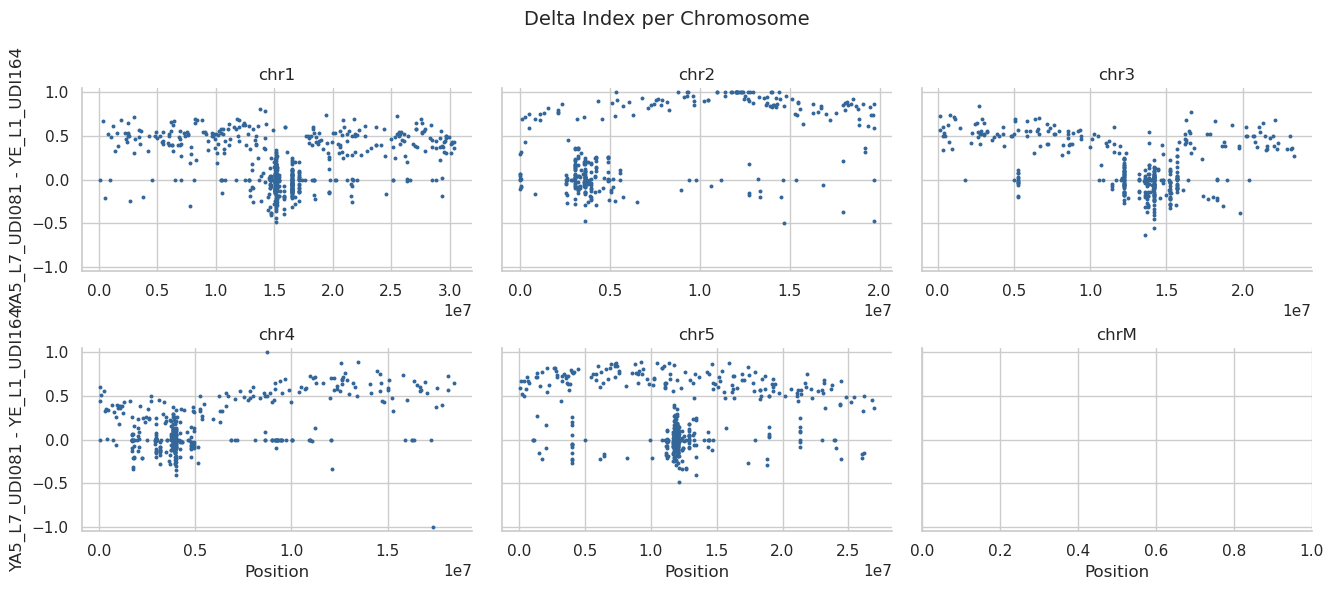

In [28]:
def parse_and_plot_vcf(vcf_path, parent, mutant, output_dir):
    import vcf
    reader = vcf.Reader(filename=vcf_path)

    # 自动匹配真实样本路径名
    parent_real, mutant_real = match_sample_names(reader.samples, parent, mutant)
    # log(f"[✓] Matched parent: {parent} → {parent_real}")
    # log(f"[✓] Matched mutant: {mutant} → {mutant_real}")

    records = []
    for record in reader:
        if record.FILTER or record.is_indel: continue
        if len(record.ALT) != 1: continue
        ref, alt = str(record.REF), str(record.ALT[0])
        if not ((ref == "G" and alt == "A") or (ref == "C" and alt == "T")): continue

        ad_parent = record.genotype(parent_real).data.AD
        ad_mutant = record.genotype(mutant_real).data.AD
        dp_parent = sum(ad_parent) if ad_parent else 0
        dp_mutant = sum(ad_mutant) if ad_mutant else 0
        idx_parent = ad_parent[1]/dp_parent if dp_parent else 0
        idx_mutant = ad_mutant[1]/dp_mutant if dp_mutant else 0
        delta = idx_mutant - idx_parent
        records.append({
            "Chr": record.CHROM, "Pos": record.POS,
            "Ref": ref, "Alt": alt,
            "Delta_Index": delta
        })

    df = pd.DataFrame(records)
    # if df.empty:
    #     log("[!] Warning: No valid SNPs found. Check filtering conditions.")
    #     return

    df["Chr"] = pd.Categorical(df["Chr"], ordered=True)
    df = df[df["Chr"].str.contains("chr", case=False)]
    df = df[df["Chr"].str.lower().isin(["chr1", "chr2", "chr3", "chr4", "chr5"])]
    # Plotting
    plot_facet_by_chr(df, parent, mutant, output_dir)

    excel_out = os.path.join(output_dir, "1_Mapping.xlsx")

    df.to_excel(excel_out, index=False)
    # log(f"[✓] Plot saved to {pdf_out}")
    # log(f"[✓] Excel saved to {excel_out}")

parse_and_plot_vcf("/bios-store1/chenyc/scripts/renlab_bsa_seq_20250606/test/4_variant/YA5_L7_UDI081_variants_filtered.vcf.gz", "YE_L1_UDI164", "YA5_L7_UDI081", "/bios-store1/chenyc/scripts/renlab_bsa_seq_20250606/test/4_variant")